# Observed Implied Storage for Shasta Reservoir
Sanity check the data for Shasta Reservoir by comparing observed implied storage and storage data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from src.data.alternate_releases import *
from src.data.data_processing import *
from src.data.data_fetching import *

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [3]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

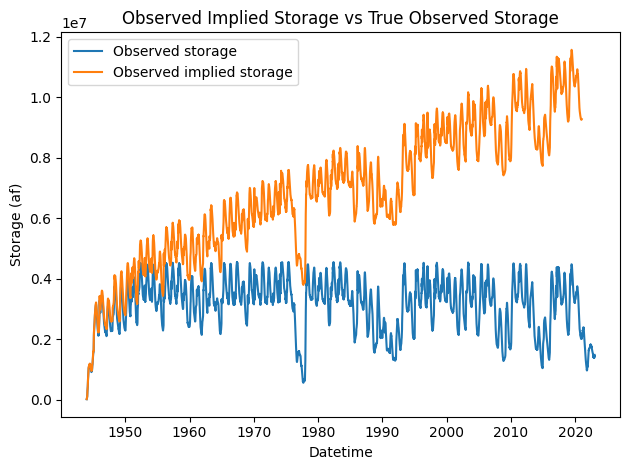

In [4]:
cfs_to_af = 86400 / 43559.9 # sec/day * af/cf
obs_implied_storage = get_implied_storage(inflow=df.inflow*cfs_to_af, 
                                          outflow=df.outflow*cfs_to_af, 
                                          initial_storage=df.storage[0], 
                                          initial_release=df.outflow[0])
plt.plot(df.storage, label='Observed storage')
plt.plot(pd.Series(obs_implied_storage, index=df.index), label='Observed implied storage')
plt.legend()
plt.ylabel('Storage (af)')
plt.xlabel('Datetime')
plt.title('Observed Implied Storage vs True Observed Storage')
plt.tight_layout()
plt.show()

Implied storages are noticeably biased when compared to real storages.

## What if we calculate releases based on storages and inflows instead?

In [5]:
# Get alternate releases from storage data
alt_releases = release_from_storage(df=df)

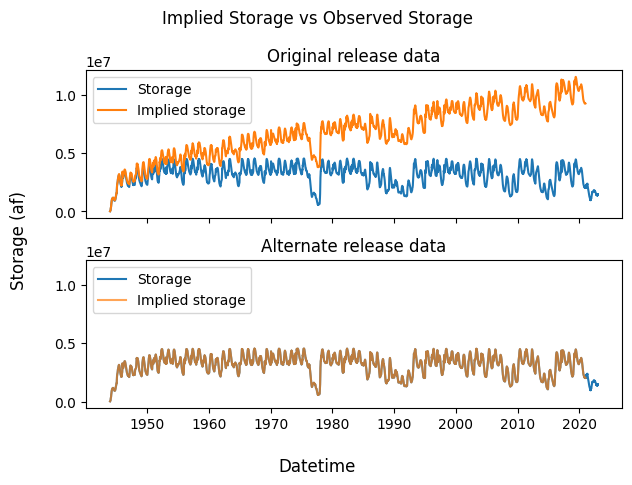

In [12]:
# Implied storage calculated from alternate releases
obs_implied_storage_alt = get_implied_storage(inflow=df.inflow*cfs_to_af, 
                                          outflow=alt_releases*cfs_to_af, 
                                          initial_storage=df.storage[0], 
                                          initial_release=df.outflow[0])

# Plot to compare
fig, axes = plt.subplots(nrows=2, sharey=True, sharex=True)
axes[0].plot(df.storage, label='Storage')
axes[0].plot(pd.Series(obs_implied_storage, index=df.index), label='Implied storage')
axes[0].set_title('Original release data')
axes[0].legend()

axes[1].plot(df.storage, label='Storage')
axes[1].plot(pd.Series(obs_implied_storage_alt, index=df.index), label='Implied storage', alpha=0.7)
axes[1].set_title('Alternate release data')
axes[1].legend(loc='upper left')

fig.supylabel('Storage (af)')
fig.supxlabel('Datetime')
fig.suptitle('Implied Storage vs Observed Storage')
plt.tight_layout()
plt.show()

As expected, the alternate releases correct the bias in the implied storage.

# Does standardization impede implied storage from reflecting true storage?
Standardize data based on statistics from the training segment. Fill NaN with training mean.

In [15]:
# Replace release data with alternate releases from storage
df.loc[:, 'outflow'] = alt_releases

# Train/val/test split
df_train, df_val, df_test = train_val_test(df, train_frac=0.6, val_frac=0.2, test_frac=0.2)

# Fill NaN with training mean
df = df.fillna(df_train.mean())

# Scale data
df_scaled = (df - df_train.mean()) / df_train.std()

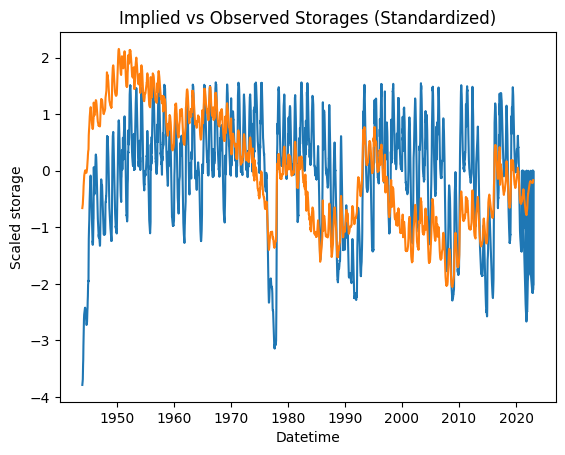

In [24]:
obs_implied_storage_scaled = get_implied_storage(inflow=df_scaled.inflow, 
                                                 outflow=df_scaled.outflow, 
                                                 initial_storage=df_scaled.storage[0], 
                                                 initial_release=df_scaled.outflow[0])
obs_implied_storage_scaled = pd.Series(obs_implied_storage_scaled, index=df_scaled.index)

plt.plot(df_scaled.storage)
plt.plot((obs_implied_storage_scaled - obs_implied_storage_scaled.mean()) / obs_implied_storage_scaled.std())
plt.title('Implied vs Observed Storages (Standardized)')
plt.xlabel('Datetime')
plt.ylabel('Scaled storage')
plt.show()